In [1]:
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
sia =SentimentIntensityAnalyzer()

In [3]:
def get_sentiment_of(sentence_in):
    try:
        scrs=sia.polarity_scores(sentence_in)
        the_important_one=scrs['compound']
    except:
        the_important_one=0
    return the_important_one

In [4]:
import pandas as pd
import csv

In [5]:
df = pd.read_csv("output_meta_yelpResData_NRYRcleaned.txt", delimiter = " ", names = [ "Date" , "review ID", "reviewer ID", "product ID", "Label", "Unknown1", "Unknown2", "reviewUsefulCount", "Star Rating"])

In [6]:
df2 = pd.read_csv("output_review_yelpResData_NRYRcleaned.txt", delimiter = "\n",names = ["review"])

In [7]:
result = pd.concat([df, df2], axis = 1)

In [8]:
f = open("output_review_yelpResData_NRYRcleaned.txt", "r")
sent = list()
for rows in f:
    #print(rows)
    sent.append(get_sentiment_of(rows))
print(len(sent))

61541


In [9]:
import numpy as np

result['Sentiment'] = sent

In [10]:
df_final = result.drop(['review ID','product ID', 'reviewer ID', 'Date', 'review' ], axis = 1)
authentic_reviews_df = df_final[df_final['Label'] == 'N']
fake_reviews_df = df_final[df_final['Label'] == 'Y']

In [11]:
authentic_reviews_df = authentic_reviews_df.sample(n = 8141)

In [12]:
df_final = pd.concat([authentic_reviews_df , fake_reviews_df])

In [13]:
df_final['Label'] = [0 if x == 'N' else 1 for x in df_final['Label']]

In [14]:
flagged = df_final['Label']
df_final = df_final.drop(['Label'], axis=1)
df_final = pd.concat([df_final,flagged], axis=1)
X = df_final.iloc[:, :-1]
y = flagged
X.head()

,Unknown1,Unknown2,reviewUsefulCount,Star Rating,Sentiment
17069,1,1,2,5,0.9810
30727,1,1,1,4,0.9940
3317,1,3,5,2,0.7587
51384,1,1,2,5,0.8921
33468,0,0,0,4,0.9290


In [15]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [17]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix

print("phase1")
svc = SVC(kernel = 'linear', gamma = 1.0)
print("phase2")
svc.fit(X_train, y_train)
print("phase3")
y_pred = svc.predict(X_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y_test, y_pred))

phase1
phase2
phase3
Accuracy Score:
0.7476205096714769


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))
dt_cm = confusion_matrix(y_test,y_pred )

              precision    recall  f1-score   support

           0       1.00      0.48      0.65      1596
           1       0.67      1.00      0.80      1661

   micro avg       0.75      0.75      0.75      3257
   macro avg       0.83      0.74      0.73      3257
weighted avg       0.83      0.75      0.73      3257



In [19]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.48 0.52]
 [0.   1.  ]]


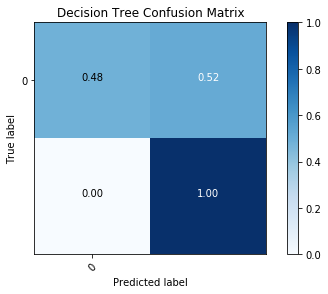

In [20]:
# Plot dt confusion matrix
plt.figure()
plot_confusion_matrix(dt_cm, classes = '0',normalize=True,
                      title='Decision Tree Confusion Matrix')
plt.show()

In [21]:
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

6
['rating', 'reviewusefulcount', 'sentiment', 'star', 'unknown1', 'unknown2']


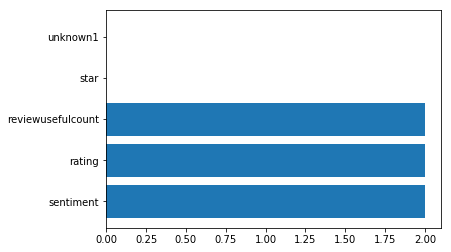

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
cv = CountVectorizer()
cv.fit(X,y)
print (len(cv.vocabulary_))
print (cv.get_feature_names())

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

features_names = cv.get_feature_names()
svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)
f_importances(abs(svc.coef_[0]), features_names, top=5)